In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/ingbiodanielh/vizwiz')

In [3]:
!ls /content/vizwiz/data/Images | wc -l

31173


In [1]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-maax7579
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-maax7579
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=f76bcd6b47862f0d98d28214541de89a942a14e9e1fb5ff03cc41d41120338cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-bs23cdsd/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [16]:
import clip
import json
import numpy as np
import torch
import torchtext
from PIL import Image
from IPython.display import Image as IM
from IPython.display import display
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
model, preprocess = clip.load('ViT-B/32', device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 148MiB/s]


In [ ]:
img = Image.open('/content/vizwiz/data/Images/VizWiz_train_000000000000.jpg')

In [ ]:
img.show()

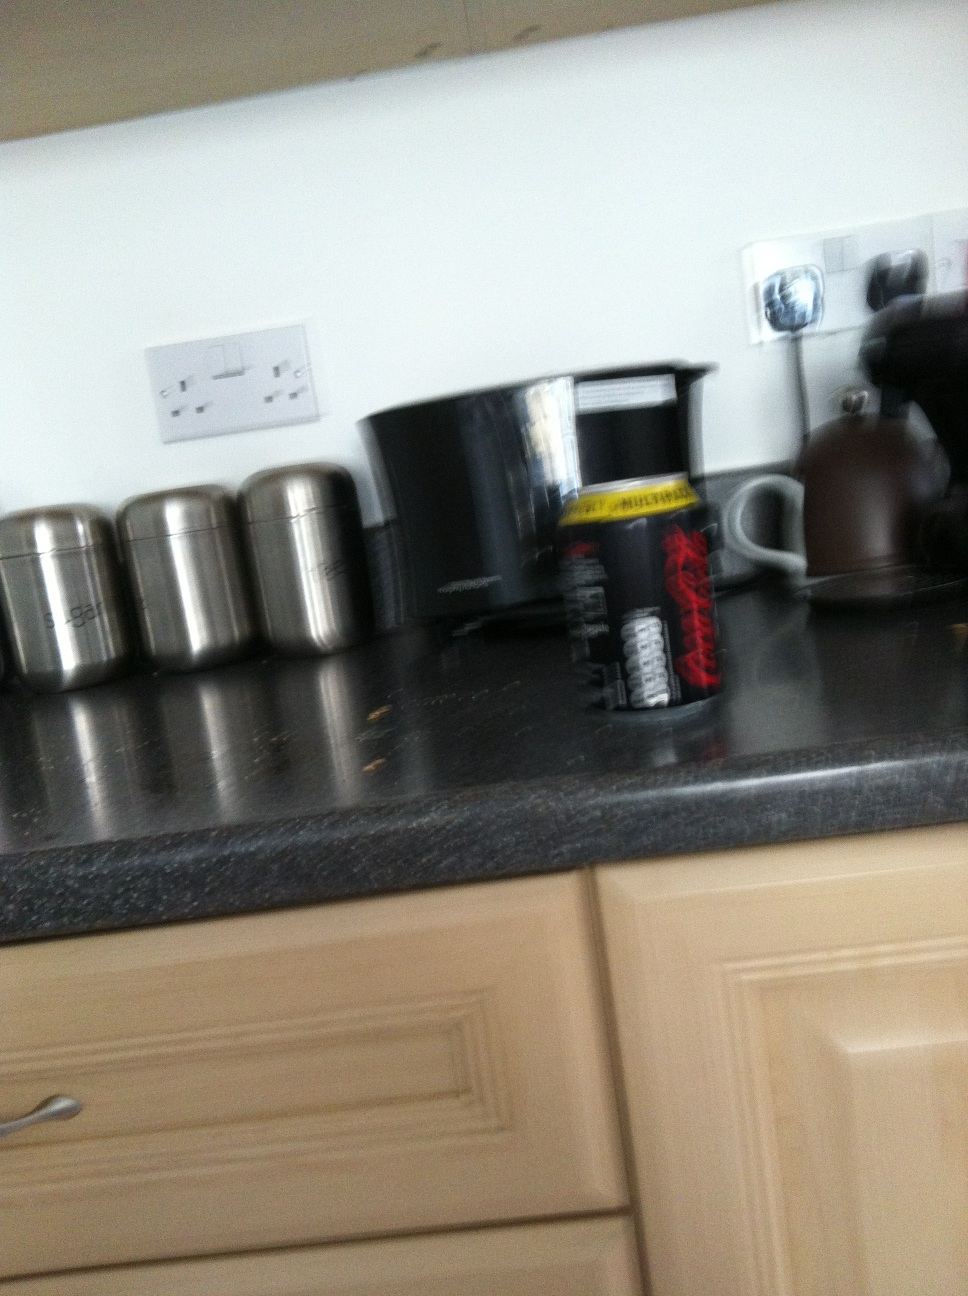

In [21]:
display(IM(filename='/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg'))

In [3]:
data = None

with open('/kaggle/input/vizwiz/data/Annotations/train.json') as f:
  data = json.load(f)

In [13]:
def get_answers_from_dict(answers_dict):
    answers = [entry['answer'] for entry in answers_dict]
    return answers

In [22]:
def get_answer(model, preprocess, img_path, answers):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = clip.tokenize(answers).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    return np.argmax(probs)

In [23]:
get_answer(model, preprocess, '/kaggle/input/vizwiz/data/Images/VizWiz_train_000000000001.jpg', get_answers_from_dict(data[1]['answers']))

5

In [19]:
get_answers_from_dict(data[1]['answers'])

['soda',
 'coca cola',
 'coca cola',
 'unsuitable',
 'unsuitable',
 'coke 0',
 'coca cola 0',
 'coke 0',
 'coca cola',
 'coke']

In [ ]:
d = {'img': 0, 'answerable': 1, 'question': 2, 'answer_type': 3, 'answer': 4}

In [25]:
df = []

for entry in data:
    idx = get_answer(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+entry['image'], get_answers_from_dict(entry['answers']))
    df.append([entry['image'], entry['answerable'], entry['question'], entry['answer_type'], entry['answers'][idx]['answer']])

df = np.array(df)

In [ ]:
with open('/kaggle/working/df.npy', 'wb') as f:
    np.save(f,df)

In [ ]:
with open('/kaggle/working/df.npy', 'rb') as f: 
    df = np.load(f)

In [26]:
answers = np.array([entry[4] for entry in df])

In [38]:
df.shape

(20000, 5)

In [49]:
suitable = np.array([entry[4] for entry in df if entry[1]=='1'])

In [51]:
len(np.unique(suitable))

9913

In [53]:
answer_types = np.array([entry[3] for entry in df])

In [54]:
def create_samples(model, preprocess, img_path, question, device):
    samples = []
    img = Image.open(img_path)
    
    encoded_q = model.encode_text(clip.tokenize(question).to(device))
    encoded_img = model.encode_image(preprocess(img).unsqueeze(0).to(device))
    samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 90 Degree
    rotated_image1 = img.rotate(90)
    encoded_img = model.encode_image(preprocess(rotated_image1).unsqueeze(0).to(device))
    samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 180 Degree
    rotated_image2 = img.rotate(180)
    encoded_img = model.encode_image(preprocess(rotated_image2).unsqueeze(0).to(device))
    samples.append(torch.hstack([encoded_img, encoded_q]))

    # Rotate Image By 270 Degree
    rotated_image3 = img.rotate(270)
    encoded_img = model.encode_image(preprocess(rotated_image3).unsqueeze(0).to(device))
    samples.append(torch.hstack([encoded_img, encoded_q]))
        
    return torch.vstack(samples)
        

In [ ]:
X = []

with torch.no_grad():
  for i in range(df.shape[0]):
    X.extend(create_samples(model, preprocess, '/kaggle/input/vizwiz/data/Images/'+df[i][0], df[i][2], device))

X = torch.vstack(X)

In [33]:
X.size()

torch.Size([3000, 1024])

In [41]:
le = preprocessing.LabelEncoder()

encoded_answer_types = le.fit_transform(answer_types)

print(encoded_answer_types[10])

1


In [42]:
le.classes_

array(['number', 'other', 'unanswerable', 'yes/no'], dtype='<U12')

In [75]:
y = [(a_type, a) for a_type, a in zip(encoded_answer_types, fin_answers)]
# y = np.array(y, dtype=object)

In [45]:
y.shape

(3000, 2)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [77]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.qtypes = []
        self.answers = []
        for qtype, ans in labels:
          self.qtypes.append(qtype)
          self.answers.append(ans)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = torch.Tensor(self.data[index])
        qy, ay = self.qtypes[index], torch.Tensor(self.answers[index])

        return x, qy, ay

In [78]:
train_set = DataLoader(VQADataset(X_train, y_train), batch_size=32)
test_set = DataLoader(VQADataset(X_test, y_test), batch_size=32)

In [93]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, seq_len, hidden_dim, embedding_dim):
        super(VQA_Network, self).__init__()

        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.fc2_answers = nn.Linear(hidden_dim, seq_len)

        self.fc2_aux = nn.Linear(hidden_dim, num_classes)
        self.fc3_aux = nn.Linear(num_classes, seq_len)

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout()
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = x.to(dtype=torch.float32)
        x = self.fc(x)
        x = self.norm(x)
        x = self.dropout(x)

        qtype = self.fc2_aux(x)
        aux = self.fc3_aux(qtype)

        answers = self.fc2_answers(x)

        answers = answers * self.softmax(aux)

        # answers = answers.to(dtype=torch.int64)

        return answers, qtype


In [ ]:
num_classes = 4
seq_len = 92
hidden_dim = 512
embedding_dim = 1024

num_epochs = 200

# Instantiate the model
model = VQA_Network(num_classes, seq_len, hidden_dim, embedding_dim).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss_a = 0.0
    running_loss_q = 0.0

    for xs, qtypeset, answerset in train_set:
        # Move data to the device
        xs = xs.to(device)
        qtypeset = qtypeset.to(device)
        answerset = answerset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        answers, qtypes = model(xs)
        # print(xs.size())
        # print(labelset.size())
        # Compute loss
        answer_loss = criterion(answers, answerset)

        # Backward pass
        answer_loss.backward(retain_graph=True)

        # Compute loss
        qtype_loss = criterion(qtypes, qtypeset)

        # Backward pass
        qtype_loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss_a += answer_loss.item()
        running_loss_q += qtype_loss.item()

    # Calculate average loss for the epoch
    average_loss_a = running_loss_a / len(train_set)
    average_loss_q = running_loss_q / len(train_set)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss_a: {average_loss_a:.4f}, Loss_q: {average_loss_q:.4f}")

# Training complete


In [ ]:
X_test[1]

In [ ]:
y_test[3]

In [ ]:
print(model(X_test[3]))